# Lab 12 - Creating an End-To-End Dialogue System

In the last lab we want to create end-to-end dialogue systems, following on from the seq2seq MT labs you've done. Customer support apps and online helpdesks are among the places where conversational models can be used. Retrieval-based models, which produce predefined responses to questions of specific types, are often used to power these models. In this lab, the seq2seq model is used to build a generative model.

To begin, download the data ZIP file from [here](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html) and place it under the current directory. 

After that, let’s import some necessities.

In [2]:
import re
import sys
import os
import random
import string
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, TimeDistributed
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional, Concatenate, Lambda
np.random.seed(1)
random.seed(1)

In [3]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

os.chdir("/content/drive/MyDrive/Colab Notebooks/NN and NLP/Lab 12/")

Mounted at /content/drive


# The Cornell Movie-Dialogs Corpus 

The next move is to reformat our data file and load the data into functional structures. 

The Cornell Movie-Dialogs Corpus contains 220,579 conversational exchanges between 10,292 pairs of movie characters, 9,035 characters from 617 movies, and 304,713 total utterances. This dataset is large with a wide variety of language formality, time periods, and other variables. Our hope is that this variety will make our model responsive to a wide range of queries.

In [4]:
#Loading the data
lines = open('cornell movie-dialogs corpus/movie_lines.txt', encoding='utf-8', errors='ignore').read().split('\n')
conv_lines = open('cornell movie-dialogs corpus/movie_conversations.txt', encoding='utf-8', errors='ignore').read().split('\n') # index of related lines

# Create a dictionary to map each id with its line
id2line = {}
for line in lines:
    _line = line.split(' +++$+++ ')
    if len(_line) == 5:
        id2line[_line[0]] = _line[4]
        
# Create a list of all of the ids.
convs = [ ]
for line in conv_lines[:-1]:
    _line = line.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(" ","")
    convs.append(_line.split(','))

# Sort the sentences into questions (inputs) and answers (targets)
pairs = []
for conv in convs:
    for i in range(len(conv)-1):
        pairs.append([id2line[conv[i]],id2line[conv[i+1]]])
        
limit = 0
for i in range(limit, limit+5):
    print(pairs[i][0])
    print(pairs[i][1])
    print()
    
len(pairs)


Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
Well, I thought we'd start with pronunciation, if that's okay with you.

Well, I thought we'd start with pronunciation, if that's okay with you.
Not the hacking and gagging and spitting part.  Please.

Not the hacking and gagging and spitting part.  Please.
Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?

You're asking me out.  That's so cute. What's your name again?
Forget it.

No, no, it's my fault -- we didn't have a proper introduction ---
Cameron.



221616

We'll format data file with a question sentence and an answer sentence pair on each line for convenience.  Before we are ready to use this data, we must perform some preprocessing.


In [5]:
def preprocess(pairs):
    p = pairs.copy()

    for i in p:
        for j in range(0,2):
            i[j] = i[j].lower()
            i[j] = re.sub(r"there's", "there is", i[j])
            i[j] = re.sub(r"i'm", "i am", i[j])
            i[j] = re.sub(r"he's", "he is", i[j])
            i[j] = re.sub(r"she's", "she is", i[j])
            i[j] = re.sub(r"it's", "it is", i[j])
            i[j] = re.sub(r"that's", "that is", i[j])
            i[j] = re.sub(r"what's", "that is", i[j])
            i[j] = re.sub(r"where's", "where is", i[j])
            i[j] = re.sub(r"how's", "how is", i[j])
            i[j] = re.sub(r"\'ll", " will", i[j])
            i[j] = re.sub(r"\'ve", " have", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"\'d", " would", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"won't", "will not", i[j])
            i[j] = re.sub(r"can't", "cannot", i[j])
            i[j] = re.sub(r"n't", " not", i[j])
            i[j] = re.sub(r"n'", "ng", i[j])
            i[j] = re.sub(r"'bout", "about", i[j])
            i[j] = re.sub(r"'til", "until", i[j])
            i[j] = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", i[j])
            i[j] = i[j].strip()
    return p

replaced_pairs = preprocess(pairs)
def clean_data(pairs):
    p = pairs.copy()
    # prepare translation table 
    table = str.maketrans('', '', string.punctuation)
    for i in p:
        # tokenize
        i[0], i[1] = i[0].split(), i[1].split()
        # convert to lower case
        i[0], i[1] = [word.lower() for word in i[0]], [word.lower() for word in i[1]]
        # remove punctuations 
        i[0], i[1] = [w.translate(table) for w in i[0]], [w.translate(table) for w in i[1]]
        # remove numbers 
        i[0], i[1] = [word for word in i[0] if word.isalpha()], [word for word in i[1] if word.isalpha()]
        # store as string
        i[0], i[1] =  ' '.join(i[0]), ' '.join(i[1])
            
    return p

clean_pairs = clean_data(replaced_pairs)
clean_pairs[:5]

[['can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again',
  'well i thought we would start with pronunciation if that is okay with you'],
 ['well i thought we would start with pronunciation if that is okay with you',
  'not the hacking and gagging and spitting part please'],
 ['not the hacking and gagging and spitting part please',
  'okay then how about we try out some french cuisine saturday night'],
 ['you are asking me out that is so cute that is your name again',
  'forget it'],
 ['no no it is my fault we did not have a proper introduction', 'cameron']]


The parsing of the raw movie lines.txt data file is made simpler with the following functions. We add the start and end tokens to our sentences. We also need to find the maximum length.



In [6]:
# adding the start and end tokens to our utterances
start_token = '<startseq>'
end_token = '<endseq>'
tokenized_pairs = []
def add_end_start_tokens(pairs):
    p = pairs.copy()
    for i in p:
        i[0] = start_token + ' '  + i[0] + ' ' + end_token
        i[1] = start_token + ' '  + i[1] + ' ' + end_token
    return p

tokenized_pairs = add_end_start_tokens(clean_pairs)
print(tokenized_pairs[:5])

# finding the maximum length for questions and answers
# we caculate the max length that covers 80% of the data 
def max_length(pairs,prct):
    # Create a list of all the utterances
    questions = []
    answers = []
    for i in pairs:
        questions.append(i[0])
        answers.append(i[1])
        
    length_questions = list(len(d.split()) for d in questions)
    length_answers = list(len(d.split()) for d in answers)

    return int(np.percentile(length_questions, prct)),int(np.percentile(length_answers, prct))

max_len_q,max_len_a = max_length(tokenized_pairs,80)

print('max-len of questions for training: ', max_len_q)
print('max-len of answers for training: ', max_len_a)

[['<startseq> can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again <endseq>', '<startseq> well i thought we would start with pronunciation if that is okay with you <endseq>'], ['<startseq> well i thought we would start with pronunciation if that is okay with you <endseq>', '<startseq> not the hacking and gagging and spitting part please <endseq>'], ['<startseq> not the hacking and gagging and spitting part please <endseq>', '<startseq> okay then how about we try out some french cuisine saturday night <endseq>'], ['<startseq> you are asking me out that is so cute that is your name again <endseq>', '<startseq> forget it <endseq>'], ['<startseq> no no it is my fault we did not have a proper introduction <endseq>', '<startseq> cameron <endseq>']]
max-len of questions for training:  18
max-len of answers for training:  18


The next step is to build a vocabulary and save query/response pairs. 
It's worth noting that we're dealing with word sequences that don't have an implicit mapping to a discrete numerical space. As a result, we must build one by assigning an index value to each unique word in our dataset.

We are going to create our vocabulary. Trimming rarely used words from our vocabulary is another strategy for achieving faster convergence during preparation. The complexity of the function that the model must learn to approximate will be lowered as the feature space is reduced.

In [7]:
# Remove questions and answers that are shorter than 2 words and longer than maxlen.
min_line_len = 2 # two words are for tokens

def set_length(tokenized_pairs):
    pairs_final = []
    for p in tokenized_pairs:
        if (
            len(p[0].split())>=min_line_len and len(p[1].split())>=min_line_len 
           and len(p[0].split())<=max_len_q and len(p[1].split())<=max_len_a):
                
            pairs_final.append(p)
            
    return pairs_final

pairs_final = set_length(tokenized_pairs)
len(pairs_final)

# making a vocabulary of the words that occur more than word_count_threshold 
def create_reoccurring_vocab(pairs, word_count_threshold = 5):
    p = pairs
    all_captions = []
    for i in p:
        for j in i:
            all_captions.append(j)

    # Consider only words which occur at least 10 times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    vocab = list(set(vocab))
    print('Short vocab size: %d ' % len(vocab))
    return vocab

# each word in the vocabulary must be used in the data at least 20 times
new_vocab = create_reoccurring_vocab(pairs_final, word_count_threshold = 4)
for v in new_vocab:
    if len(v) == 1 and v!='a' and v!='i':
        new_vocab.remove(v) 

new_vocab = sorted(new_vocab)[1:]
new_vocab[:5]

Short vocab size: 14524 


['<endseq>', '<startseq>', 'a', 'aa', 'aaaah']

In [8]:
vocab_len = len(new_vocab) + 1 # since index 0 is used as padding, we have to increase the vocab size
vocab_len


14500

We are going to create a dataset of pairs without the trimmed words.

In [9]:
def progressBar(value, endvalue, bar_length=20, job=''):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} : [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()
    
def print_tensor(t):
    print(K.get_value(t))
    
def to_tensor(t):
    return tf.convert_to_tensor(t)

In [ ]:
# keeping the pairs with words in the vocab
def trimRareWords(voc, pairs):
    # Filtering out the pairs with the oov words
    keep_pairs = []
    i=0
    for pair in pairs:
        i+=1
        progressBar(value=i,endvalue=len(pairs))
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        #  input sentence
        for word in input_sentence.split(' '):
            if word not in voc:
                keep_input = False
                break
        #  output sentence
        for word in output_sentence.split(' '):
            if word not in voc:
                keep_output = False
                break

        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("\nTrimmed from {} pairs to {}".format(len(pairs), len(keep_pairs)))
    return keep_pairs


# # Trim voc and pairs
pairs_final = trimRareWords(new_vocab, pairs_final)
with open ('final_pairs_v21.pkl','wb') as f:
    pairs_final = pickle.dump(pairs_final,f)
    
with open ('final_pairs_v21.pkl','rb') as f:
    pairs_final = pickle.load(f)
    
pairs_final_train = pairs_final
len(pairs_final_train)

 : [------------------->] 100%
Trimmed from 145905 pairs to 114938


114938

In [10]:
with open ('final_pairs_v21.pkl','rb') as f:
    pairs_final = pickle.load(f)
    
pairs_final_train = pairs_final
len(pairs_final_train)

114938

# Embedding layer

Our models will eventually expect numerical tensors as inputs, despite the fact that we put a lot of effort into preparing and massaging our data into a nice vocabulary object and list of sentence pairs. The Embedding layer can be used to load a pre-trained word embedding model. We are going to use GloVe embeddings. You can download GloVe and we can seed the Keras Embedding layer with weights from the pre-trained embedding for the words in your dataset.

In [11]:
test = False
GRU_units = 50
batch_size = 32
emb_dim = 50
init_lr = 0.001

#Create an instance of the tokenizer object:
tokenizer = Tokenizer(filters = [])
tokenizer.fit_on_texts(new_vocab)

ixtoword = {} # index to word dic
wordtoix = tokenizer.word_index # word to index dic
pad_token = 'pad0'
ixtoword[0] = pad_token # no word in vocab has index 0,  padding is indicated with 0

for w in tokenizer.word_index:
    ixtoword[tokenizer.word_index[w]] = w

# Making the embedding mtrix
def make_embedding_layer(embedding_dim=50, glove=True):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # just a zero matrix 
    else:
        print('Loading glove...')
        embeddings_index = {} 
        f = open(os.path.join('glove.6B.50d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        print("GloVe ",embedding_dim, ' loaded!')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words that are not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
            
    embedding_layer = Embedding(vocab_len, embedding_dim, mask_zero=True, trainable=False) # we have a limited vocab so we 
                                                                                           # do not train the embedding layer
                                                                                           # we use 0 as padding so => mask_zero=True
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    
    return embedding_layer

embeddings = make_embedding_layer(embedding_dim=50, glove=not test)

Loading glove...
GloVe  50  loaded!


# Seq2Seq Model



A sequence-to-sequence (seq2seq) model is at the core of our model. The purpose of a seq2seq model is to use a fixed-sized sequence as an input and generate a variable-length sequence as an output.

[Sutskever et al.](https://arxiv.org/abs/1409.3215) found that we can do this task by combining two different recurrent neural nets. One  RNN serves as an encoder, converting a variable-length input sequence to a fixed-length context vector. This context vector (the RNN's final hidden layer) contain semantic knowledge about the query sentence that the system receives.



# Encoder

The encoder RNN iterates through the input sentence one token at a time, producing an "output" vector and a "hidden state" vector at each time step.  The output vector is recorded while the hidden state vector is transferred to the next time step. The encoder converts the context it observed at each point in the sequence into a set of points in a high-dimensional space, which the decoder can use to produce a meaningful output for the task at hand.

A multi-layered Gated Recurrent Unit, created by [Cho et al.](https://arxiv.org/pdf/1406.1078v3.pdf), is at the centre of our encoder. We'll use a bidirectional version of the GRU, which effectively means there are two separate RNNs: one fed the input sequence in regular sequential order and the other fed the input sequence in reverse order. At each time point, the outputs of each network are added together.

***For the first task you need to define a bidirectional GRU and pass the embedding into the GRU. ***

In [12]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.batch_sz = batch_size
        self.enc_units = enc_units

        #  pass the embedding into a bidirectional version of the GRU - as you can see in the call() method below, you can use just 1 GRU layer but could experiment with more
        self.embeddings = embeddings
        self.Bidirectional1 = Bidirectional(GRU(enc_units, return_sequences=True))
        self.Bidirectional2 = Bidirectional(GRU(enc_units, return_sequences=True, return_state=True))
                                                                                    
        self.dropout = Dropout(0.2)
        self.Inp = Input(shape=(max_len_q,)) # size of questions
            
    def bidirectional(self, bidir, layer, inp, hidden):
        return bidir(layer(inp, initial_state = hidden))
    
    def call(self, x, hidden):
        x = self.embeddings(x)
        x = self.dropout(x)
        x = self.Bidirectional1(x)
        x = self.dropout(x)
        output, state_f,state_b = self.Bidirectional2(x)

        return output, state_f, state_b

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))


In [13]:
encoder = Encoder(vocab_len, 50, GRU_units)


# Decoder

The response utterance is produced token by token by the decoder RNN. It generates the next word in the sequence using the encoder's context vectors and internal hidden states. It keeps producing words until it reaches the end of the sentence, which is represented by an end_token. A common issue with a standard seq2seq decoder is that relying solely on the context vector to encode the meaning of the complete input sequence would almost certainly result in information loss. This is particularly true when dealing with long input sequences, severely restricting our decoder's capabilities.

[Bahdanau et al.](https://arxiv.org/abs/1409.0473) devised an "attention mechanism" that allows the decoder to focus on specific parts of the input sequence rather than using the whole set context at each step to deal with information loss. Attention is determined using the encoder's outputs and the decoder's current hidden state. Since the output attention weights have the same shape as the input sequence, we may multiply them by the encoder outputs to get a weighted amount that shows which sections of the encoder output to focus on.

**For the second task you need to create the decoder with attention. Call the attention layer and use GRUs for decoding.**

In [14]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units = units
        
    def call(self, query, values):
        
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [15]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.batch_sz = batch_size
        self.embeddings = embeddings
        self.units = 2 * dec_units # because we use bidirectional encoder
        self.fc = Dense(vocab_len, activation='softmax', name='dense_layer')
        # Create the decoder with attention - as you'll see in the call() method below, it will need two GRU layers

        self.attention = BahdanauAttention(self.units) # called Attention Layer defined above

        self.decoder_gru_l1 = GRU(self.units, return_sequences=True) # GRU for decoder instead of BiDirectional GRU

        self.decoder_gru_l2 = GRU(self.units, return_sequences=False, return_state=True) 

        self.dropout = Dropout(0.2)


        
    def call(self, x, hidden, enc_output):

        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embeddings(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) # concat input and context vector together

        # passing the concatenated vector to the GRU
        x = self.decoder_gru_l1(x)
        x = self.dropout(x)
        output, state = self.decoder_gru_l2(x)
        x = self.fc(output)
        return x, state, attention_weights

In [16]:
decoder = Decoder(vocab_len, 50, GRU_units)


# Evaluation

We can now write functions to evaluate a string input sentence now that we've established our decoding process. The evaluate function is in charge of the low-level handling of the input sentence. The sentence is first formatted as an input batch of word indexes. To prepare the tensor for our models, we convert the words of the sentence to their corresponding indexes and transpose the dimensions. Our system's user interface is called answer. Our text is normalised in the same way that our training data is, and then fed into the evaluate function to generate a decoded output sentence and attention weights.

In [17]:
import unicodedata
import matplotlib.ticker as ticker

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Added Attention Weights in the plot
    for i in range(len(attention)):
        for j in range(len(attention)):
            text = ax.text(j, i, attention[i, j], ha="center", va="center", color="w")
    
    plt.show()

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def evaluate(sentence):
    
    attention_plot = np.zeros((max_len_a, max_len_q))

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoix[start_token]], 1)

    for t in range(max_len_a):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = K.get_value(attention_weights)
        
        #print(predictions[0])
        predicted_id =  K.get_value(tf.argmax(predictions[0]))
        #print(f'predicted id: {predicted_id}')

        if ixtoword[predicted_id] == end_token:
            return result, sentence, attention_plot
        
        result += ixtoword[predicted_id] + ' '
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 1)

    return result, sentence, attention_plot

def answer(sentence, training=False):
    result, sentence, attention_plot = evaluate(sentence)
    
    if training:
        return result
    
    print('Input: %s' % (sentence))
    print('Predicted answer: {}'.format(result))
    attention_plot = attention_plot[1:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' ')[:-1])

# Greedy decoding

Greedy decoding is a decoding method in which we simply choose the highest softmax value word from decoder output for each time stage. On a single time-step stage, this decoding method is optimal. It is common in neural machine translation systems to use a beam-search to sample the probabilities for the words in the sequence output by the model.

The wider the beam width, the more exhaustive the search, and, it is believed, the better the results.

The results showed that a modest beam-width of 3-5 performed the best, which could be improved only very slightly through the use of length penalties. 

In [18]:
def beam_search(sentence, k=5, maxsample=max_len_a, use_unk=False, oov=None, eos=end_token):

    
    dead_k = 0 # samples that reached eos
    dead_samples = []
    dead_scores = []
    live_k = 1 # samples that did not yet reached eos
    live_samples = [[wordtoix[start_token]]]
    live_scores = [0]

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoix[start_token]], 0)
        
    while live_k and dead_k < k:
        # for every possible live sample calc prob for every possible label 
        predictions, dec_hidden, _ = decoder(dec_input,dec_hidden,enc_out)
        probs = K.get_value(predictions[0])
        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        cand_flat = cand_scores.flatten()

        # find the best (lowest) scores we have from all possible samples and new words
        ranks_flat = cand_flat.argsort()[:(k-dead_k)]
        live_scores = cand_flat[ranks_flat]

        # append the new words to their appropriate live sample
        voc_size = vocab_len
        live_samples = [live_samples[r//voc_size]+[r%voc_size] for r in ranks_flat]

        # live samples that should be dead are...
        zombie = [s[-1] == eos or len(s) >= maxsample for s in live_samples]
        
        # add zombies to the dead
        dead_samples += [s for s,z in zip(live_samples,zombie) if z]  # remove first label == empty
        dead_scores += [s for s,z in zip(live_scores,zombie) if z]
        dead_k = len(dead_samples)
        # remove zombies from the living 
        live_samples = [s for s,z in zip(live_samples,zombie) if not z]
        live_scores = [s for s,z in zip(live_scores,zombie) if not z]
        live_k = len(live_samples)

    final_samples = dead_samples + live_samples
    final_scores = dead_scores + live_scores   
    
    # cutting the strong where end_token is encounterd
    for i in range(len(final_scores)):
        final_scores[i] /= len(final_samples[i]) # normalizing the scores
    
    final_result =[]
    
    for i in range(len(final_scores)):
        final_result.append((final_scores[i],final_samples[i]))
    
    final_list_ix = max(final_result)[1]
    final_list_word = [ixtoword[f] for f in final_list_ix]
    final_sentence = ' '.join(final_list_word[1:])
    end_ix = final_sentence.find(end_token)
    return final_sentence[:end_ix]

# Training procedure

# Masked loss

We can't simply consider all elements of the tensor when evaluating loss because we're dealing with batches of padded sequences. Based on our decoder's output tensor, the target tensor, and a binary mask tensor describing the padding of the target tensor, we define a function to measure our loss.

In [19]:
optimizer = tf.keras.optimizers.Adam(init_lr)

def loss_function(real, pred):

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [20]:
# checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(str(emb_dim)+"-ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


# Single training iteration

The algorithm for a single training iteration is contained in the train_step function (a single batch of inputs). To help with convergence, we'll use teacher forcing. This means that we use the current target word as the decoder's next input rather than the decoder's current guess in some probabilities. This technique serves as decoder training wheels, allowing for more effective training. However, since the decoder may not have had enough time to truly craft its own output sequences during training, teacher forcing can lead to model instability during inference. 



In [21]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden_f, enc_hidden_b = encoder(inp, enc_hidden)
        
        dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
        dec_input = tf.expand_dims([wordtoix[start_token]] * batch_size, 1) # dec_input initially == start_token

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions) # each time just use one timestep output
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1) # expected output at this time becomes input for next timestep
            
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [22]:
history={'loss':[]}
smallest_loss = np.inf
best_ep = 1
EPOCHS = 150 # but 150 is enough
enc_hidden = encoder.initialize_hidden_state()
steps_per_epoch = len(pairs_final_train)//batch_size # used for caculating number of batches
current_ep = 1


We are creating a test_bot to monitor our training in every time step.

In [23]:
def test_bot(k = 5, beam = False):
    print('#'*20)
    q = 'Hello'
    print('Greedy| Q:',q,'  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'  A:',beam_search(q,k=k))
    print('%')
    q = 'How are you'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')

    q = 'What are you doing'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'What is your favorite restaurant'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
  
    q = 'Do you want to go out'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('#'*20)

# Training iterations

It's finally time to link the entire training procedure to the data. Given the passed models, optimizers, data, and so on, the function is responsible for running n iterations of training. We've already done the heavy lifting with the train_step function, so this function is self-explanatory.

One thing to keep in mind is that when we save our model, the encoder and decoder parameters, the optimizer parameters, the loss, the iteration, and so on are all saved. This method of saving the model will give us the most flexibility with the checkpoint. We can use the model parameters to run inference after loading a checkpoint, or we can begin training where we left off.

Epoch 1 Batch 598 Loss: 2.0946
Epoch 1 Batch 1196 Loss: 2.3501
Epoch 1 Batch 1794 Loss: 2.1536
Epoch 1 Batch 2392 Loss: 2.1432
Epoch 1 Batch 2990 Loss: 1.9138
Epoch 1 Batch 3588 Loss: 2.2917

*** Epoch 1 Loss 2.1010 ***

####################
Greedy| Q: Hello   A: i am not 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  1
Time  223.193 sec

Epoch 2 Batch 598 Loss: 1.7500
Epoch 2 Batch 1196 Loss: 2.3696
Epoch 2 Batch 1794 Loss: 2.3110
Epoch 2 Batch 2392 Loss: 2.3424
Epoch 2 Batch 2990 Loss: 1.7586
Epoch 2 Batch 3588 Loss: 2.2135

*** Epoch 2 Loss 1.8741 ***

####################
Greedy| Q: Hello   A: yes 
%
Greedy| Q: How are you ?  A: i am not a good of the way 
%
Greedy| Q: What are you doing ?  A: i am not a good of the way 
%
Greedy| Q: What is your favorite restaurant ?  

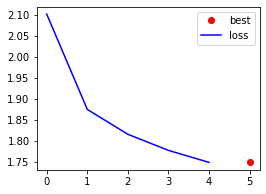

Best epoch so far:  5
Time  175.756 sec

Epoch 6 Batch 598 Loss: 1.5417
Epoch 6 Batch 1196 Loss: 1.9046
Epoch 6 Batch 1794 Loss: 1.7951
Epoch 6 Batch 2392 Loss: 1.8932
Epoch 6 Batch 2990 Loss: 1.6460
Epoch 6 Batch 3588 Loss: 1.9766

*** Epoch 6 Loss 1.7251 ***

####################
Greedy| Q: Hello   A: hi 
%
Greedy| Q: How are you ?  A: i am not going to be a good time 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
check point saved!
Best epoch so far:  6
Time  175.151 sec

Epoch 7 Batch 598 Loss: 1.6557
Epoch 7 Batch 1196 Loss: 2.1229
Epoch 7 Batch 1794 Loss: 2.0881
Epoch 7 Batch 2392 Loss: 2.1759
Epoch 7 Batch 2990 Loss: 1.5088
Epoch 7 Batch 3588 Loss: 1.9782

*** Epoch 7 Loss 1.7073 ***

####################
Greedy| Q: Hello   A: hi 
%
Greedy| Q: How are you ?  A: i am not going to be a good time 
%
Greedy| Q: Wh

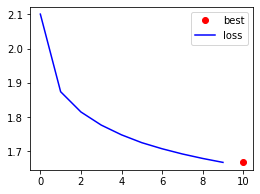

Best epoch so far:  10
Time  173.997 sec

Epoch 11 Batch 598 Loss: 1.4859
Epoch 11 Batch 1196 Loss: 1.8288
Epoch 11 Batch 1794 Loss: 1.6939
Epoch 11 Batch 2392 Loss: 1.8849
Epoch 11 Batch 2990 Loss: 1.5909
Epoch 11 Batch 3588 Loss: 1.9034

*** Epoch 11 Loss 1.6566 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am sorry 
%
Greedy| Q: What are you doing ?  A: i am sorry 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  11
Time  172.508 sec

Epoch 12 Batch 598 Loss: 1.6338
Epoch 12 Batch 1196 Loss: 2.0136
Epoch 12 Batch 1794 Loss: 1.9112
Epoch 12 Batch 2392 Loss: 2.1305
Epoch 12 Batch 2990 Loss: 1.4280
Epoch 12 Batch 3588 Loss: 1.8376

*** Epoch 12 Loss 1.6475 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am sorry 
%
Greedy| Q: What are you doing ?  A: i am sorry 
%
Greedy| Q: What i

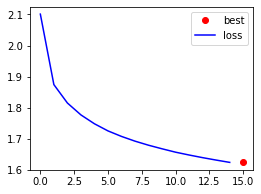

Best epoch so far:  15
Time  175.731 sec

Epoch 16 Batch 598 Loss: 1.4112
Epoch 16 Batch 1196 Loss: 1.8601
Epoch 16 Batch 1794 Loss: 1.6836
Epoch 16 Batch 2392 Loss: 1.9131
Epoch 16 Batch 2990 Loss: 1.6031
Epoch 16 Batch 3588 Loss: 1.7656

*** Epoch 16 Loss 1.6171 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am sorry 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry i am sorry i am sorry i am sorry i am sorry i am sorry 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  16
Time  174.633 sec

Epoch 17 Batch 598 Loss: 1.5106
Epoch 17 Batch 1196 Loss: 1.7408
Epoch 17 Batch 1794 Loss: 1.7213
Epoch 17 Batch 2392 Loss: 1.7835
Epoch 17 Batch 2990 Loss: 1.5559
Epoch 17 Batch 3588 Loss: 1.5848

*** Epoch 17 Loss 1.6109 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: Wha

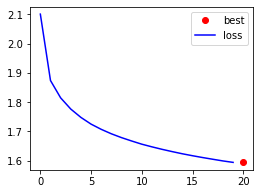

Best epoch so far:  20
Time  173.006 sec

Epoch 21 Batch 598 Loss: 1.3737
Epoch 21 Batch 1196 Loss: 1.9032
Epoch 21 Batch 1794 Loss: 1.8255
Epoch 21 Batch 2392 Loss: 1.9214
Epoch 21 Batch 2990 Loss: 1.6230
Epoch 21 Batch 3588 Loss: 1.8380

*** Epoch 21 Loss 1.5895 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not sure 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  21
Time  173.428 sec

Epoch 22 Batch 598 Loss: 1.4625
Epoch 22 Batch 1196 Loss: 1.7360
Epoch 22 Batch 1794 Loss: 1.6902
Epoch 22 Batch 2392 Loss: 1.8042
Epoch 22 Batch 2990 Loss: 1.4849
Epoch 22 Batch 3588 Loss: 1.6162

*** Epoch 22 Loss 1.5846 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not going to be a little ti

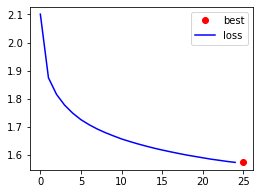

Best epoch so far:  25
Time  173.019 sec

Epoch 26 Batch 598 Loss: 1.4169
Epoch 26 Batch 1196 Loss: 1.9583
Epoch 26 Batch 1794 Loss: 1.9384
Epoch 26 Batch 2392 Loss: 1.8396
Epoch 26 Batch 2990 Loss: 1.6345
Epoch 26 Batch 3588 Loss: 1.9041

*** Epoch 26 Loss 1.5693 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not sure 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  26
Time  173.367 sec

Epoch 27 Batch 598 Loss: 1.4510
Epoch 27 Batch 1196 Loss: 1.7623
Epoch 27 Batch 1794 Loss: 1.6269
Epoch 27 Batch 2392 Loss: 1.8360
Epoch 27 Batch 2990 Loss: 1.4745
Epoch 27 Batch 3588 Loss: 1.6786

*** Epoch 27 Loss 1.5651 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am seventyfour 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: Wh

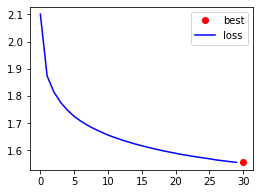

Best epoch so far:  30
Time  173.811 sec

Epoch 31 Batch 598 Loss: 1.2787
Epoch 31 Batch 1196 Loss: 2.0909
Epoch 31 Batch 1794 Loss: 1.8965
Epoch 31 Batch 2392 Loss: 1.9233
Epoch 31 Batch 2990 Loss: 1.5990
Epoch 31 Batch 3588 Loss: 1.9155

*** Epoch 31 Loss 1.5533 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am seventyfour 
%
Greedy| Q: What are you doing ?  A: i am not going to be a good time 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not sure 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  31
Time  171.371 sec

Epoch 32 Batch 598 Loss: 1.3895
Epoch 32 Batch 1196 Loss: 1.7839
Epoch 32 Batch 1794 Loss: 1.6682
Epoch 32 Batch 2392 Loss: 1.8882
Epoch 32 Batch 2990 Loss: 1.5107
Epoch 32 Batch 3588 Loss: 1.6445

*** Epoch 32 Loss 1.5504 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am seventyfour 
%
Greedy| Q: What are you doing 

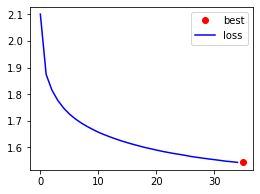

Best epoch so far:  35
Time  212.085 sec

Epoch 36 Batch 598 Loss: 1.3221
Epoch 36 Batch 1196 Loss: 2.1195
Epoch 36 Batch 1794 Loss: 1.8669
Epoch 36 Batch 2392 Loss: 1.9263
Epoch 36 Batch 2990 Loss: 1.6009
Epoch 36 Batch 3588 Loss: 1.8003

*** Epoch 36 Loss 1.5398 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not going to be a good time 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not sure 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  36
Time  211.872 sec

Epoch 37 Batch 598 Loss: 1.3377
Epoch 37 Batch 1196 Loss: 1.8479
Epoch 37 Batch 1794 Loss: 1.8049
Epoch 37 Batch 2392 Loss: 1.9003
Epoch 37 Batch 2990 Loss: 1.5527
Epoch 37 Batch 3588 Loss: 1.7532

*** Epoch 37 Loss 1.5381 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not

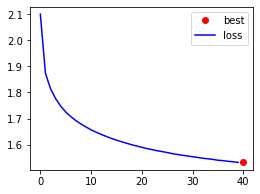

Best epoch so far:  40
Time  182.686 sec

Epoch 41 Batch 598 Loss: 1.3589
Epoch 41 Batch 1196 Loss: 2.0588
Epoch 41 Batch 1794 Loss: 2.0012
Epoch 41 Batch 2392 Loss: 1.9038
Epoch 41 Batch 2990 Loss: 1.5927
Epoch 41 Batch 3588 Loss: 1.8061

*** Epoch 41 Loss 1.5297 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am going to be a good time 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not sure 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  41
Time  163.130 sec

Epoch 42 Batch 598 Loss: 1.3833
Epoch 42 Batch 1196 Loss: 1.9173
Epoch 42 Batch 1794 Loss: 1.9117
Epoch 42 Batch 2392 Loss: 1.8007
Epoch 42 Batch 2990 Loss: 1.5853
Epoch 42 Batch 3588 Loss: 1.8443

*** Epoch 42 Loss 1.5282 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not goi

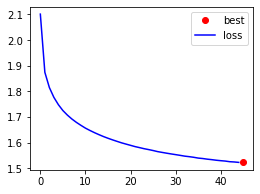

Best epoch so far:  45
Time  162.709 sec

Epoch 46 Batch 598 Loss: 1.4329
Epoch 46 Batch 1196 Loss: 1.9676
Epoch 46 Batch 1794 Loss: 1.9292
Epoch 46 Batch 2392 Loss: 1.8820
Epoch 46 Batch 2990 Loss: 1.5406
Epoch 46 Batch 3588 Loss: 1.8361

*** Epoch 46 Loss 1.5212 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not going to be a good time 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not sure 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  46
Time  161.783 sec

Epoch 47 Batch 598 Loss: 1.2561
Epoch 47 Batch 1196 Loss: 2.0601
Epoch 47 Batch 1794 Loss: 1.8426
Epoch 47 Batch 2392 Loss: 1.8968
Epoch 47 Batch 2990 Loss: 1.5631
Epoch 47 Batch 3588 Loss: 1.8585

*** Epoch 47 Loss 1.5198 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not

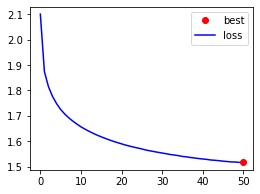

Best epoch so far:  50
Time  161.673 sec

Epoch 51 Batch 598 Loss: 1.4254
Epoch 51 Batch 1196 Loss: 1.9920
Epoch 51 Batch 1794 Loss: 1.9103
Epoch 51 Batch 2392 Loss: 1.9982
Epoch 51 Batch 2990 Loss: 1.5427
Epoch 51 Batch 3588 Loss: 1.9410

*** Epoch 51 Loss 1.5144 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am going to be a good time 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not sure 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  51
Time  163.275 sec

Epoch 52 Batch 598 Loss: 1.2962
Epoch 52 Batch 1196 Loss: 2.0595
Epoch 52 Batch 1794 Loss: 1.8222
Epoch 52 Batch 2392 Loss: 1.8921
Epoch 52 Batch 2990 Loss: 1.5843
Epoch 52 Batch 3588 Loss: 1.7518

*** Epoch 52 Loss 1.5127 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am going t

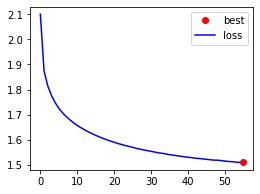

Best epoch so far:  55
Time  163.915 sec

Epoch 56 Batch 598 Loss: 1.4362
Epoch 56 Batch 1196 Loss: 1.9396
Epoch 56 Batch 1794 Loss: 1.8934
Epoch 56 Batch 2392 Loss: 1.9546
Epoch 56 Batch 2990 Loss: 1.5550
Epoch 56 Batch 3588 Loss: 1.8062

*** Epoch 56 Loss 1.5077 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  56
Time  162.967 sec

Epoch 57 Batch 598 Loss: 1.3347
Epoch 57 Batch 1196 Loss: 2.0091
Epoch 57 Batch 1794 Loss: 1.9647
Epoch 57 Batch 2392 Loss: 1.8759
Epoch 57 Batch 2990 Loss: 1.5688
Epoch 57 Batch 3588 Loss: 1.7779

*** Epoch 57 Loss 1.5086 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am going to do 
%
Greedy|

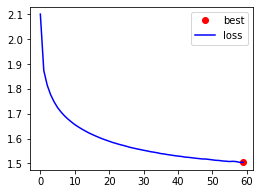

Best epoch so far:  59
Time  162.130 sec

Epoch 61 Batch 598 Loss: 1.4424
Epoch 61 Batch 1196 Loss: 1.8871
Epoch 61 Batch 1794 Loss: 1.8702
Epoch 61 Batch 2392 Loss: 1.9754
Epoch 61 Batch 2990 Loss: 1.5333
Epoch 61 Batch 3588 Loss: 1.8127

*** Epoch 61 Loss 1.5022 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am going to be a good time 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not sure 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  61
Time  161.556 sec

Epoch 62 Batch 598 Loss: 1.4231
Epoch 62 Batch 1196 Loss: 1.9770
Epoch 62 Batch 1794 Loss: 1.9066
Epoch 62 Batch 2392 Loss: 1.8410
Epoch 62 Batch 2990 Loss: 1.4994
Epoch 62 Batch 3588 Loss: 1.8248

*** Epoch 62 Loss 1.5031 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am going t

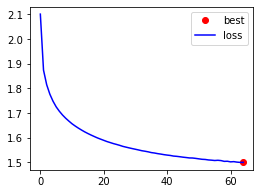

Best epoch so far:  64
Time  161.387 sec

Epoch 66 Batch 598 Loss: 1.4428
Epoch 66 Batch 1196 Loss: 1.8085
Epoch 66 Batch 1794 Loss: 1.8798
Epoch 66 Batch 2392 Loss: 1.9562
Epoch 66 Batch 2990 Loss: 1.4549
Epoch 66 Batch 3588 Loss: 1.7374

*** Epoch 66 Loss 1.4973 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am going to be a seizure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  66
Time  161.819 sec

Epoch 67 Batch 598 Loss: 1.4088
Epoch 67 Batch 1196 Loss: 2.0067
Epoch 67 Batch 1794 Loss: 1.8939
Epoch 67 Batch 2392 Loss: 1.9561
Epoch 67 Batch 2990 Loss: 1.5368
Epoch 67 Batch 3588 Loss: 1.9159

*** Epoch 67 Loss 1.4973 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am going to do 

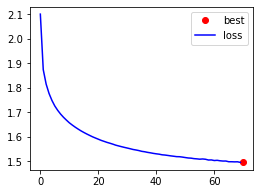

Best epoch so far:  70
Time  161.935 sec

Epoch 71 Batch 598 Loss: 1.4526
Epoch 71 Batch 1196 Loss: 1.7904
Epoch 71 Batch 1794 Loss: 1.8647
Epoch 71 Batch 2392 Loss: 1.9480
Epoch 71 Batch 2990 Loss: 1.3648
Epoch 71 Batch 3588 Loss: 1.6767

*** Epoch 71 Loss 1.4935 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am going to be a good time 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry i am sorry 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  71
Time  161.105 sec

Epoch 72 Batch 598 Loss: 1.4302
Epoch 72 Batch 1196 Loss: 1.9374
Epoch 72 Batch 1794 Loss: 1.8790
Epoch 72 Batch 2392 Loss: 1.9097
Epoch 72 Batch 2990 Loss: 1.5392
Epoch 72 Batch 3588 Loss: 1.7808

*** Epoch 72 Loss 1.4927 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am

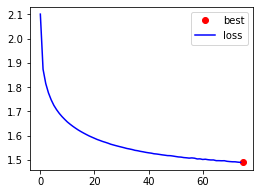

Best epoch so far:  75
Time  161.097 sec

Epoch 76 Batch 598 Loss: 1.4529
Epoch 76 Batch 1196 Loss: 1.8088
Epoch 76 Batch 1794 Loss: 1.7600
Epoch 76 Batch 2392 Loss: 1.9350
Epoch 76 Batch 2990 Loss: 1.3250
Epoch 76 Batch 3588 Loss: 1.6446

*** Epoch 76 Loss 1.4911 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am going to be a good time 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry i am sorry i am sorry i am sorry i am sorry i am sorry 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  75
Time  162.205 sec

Epoch 77 Batch 598 Loss: 1.4104
Epoch 77 Batch 1196 Loss: 1.8837
Epoch 77 Batch 1794 Loss: 1.8573
Epoch 77 Batch 2392 Loss: 1.9518
Epoch 77 Batch 2990 Loss: 1.5328
Epoch 77 Batch 3588 Loss: 1.7867

*** Epoch 77 Loss 1.4895 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What

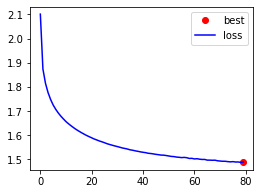

Best epoch so far:  79
Time  162.311 sec

Epoch 81 Batch 598 Loss: 1.4481
Epoch 81 Batch 1196 Loss: 1.5901
Epoch 81 Batch 1794 Loss: 1.6264
Epoch 81 Batch 2392 Loss: 1.6903
Epoch 81 Batch 2990 Loss: 1.4163
Epoch 81 Batch 3588 Loss: 1.3638

*** Epoch 81 Loss 1.4877 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not going to be a seizure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry i am sorry i am sorry i am sorry i am sorry i am sorry 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  81
Time  162.903 sec

Epoch 82 Batch 598 Loss: 1.4252
Epoch 82 Batch 1196 Loss: 1.7933
Epoch 82 Batch 1794 Loss: 1.8554
Epoch 82 Batch 2392 Loss: 1.9203
Epoch 82 Batch 2990 Loss: 1.4733
Epoch 82 Batch 3588 Loss: 1.6984

*** Epoch 82 Loss 1.4861 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fi

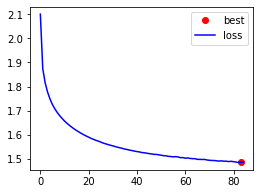

Best epoch so far:  83
Time  163.948 sec

Epoch 86 Batch 598 Loss: 1.4259
Epoch 86 Batch 1196 Loss: 1.6090
Epoch 86 Batch 1794 Loss: 1.5861
Epoch 86 Batch 2392 Loss: 1.7182
Epoch 86 Batch 2990 Loss: 1.3746
Epoch 86 Batch 3588 Loss: 1.4273

*** Epoch 86 Loss 1.4823 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am going to be a good time 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  86
Time  163.156 sec

Epoch 87 Batch 598 Loss: 1.4422
Epoch 87 Batch 1196 Loss: 1.7895
Epoch 87 Batch 1794 Loss: 1.8421
Epoch 87 Batch 2392 Loss: 1.9062
Epoch 87 Batch 2990 Loss: 1.3541
Epoch 87 Batch 3588 Loss: 1.6701

*** Epoch 87 Loss 1.4842 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am going to be 

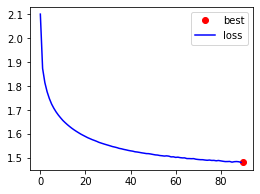

Best epoch so far:  90
Time  165.350 sec

Epoch 91 Batch 598 Loss: 1.4212
Epoch 91 Batch 1196 Loss: 1.6580
Epoch 91 Batch 1794 Loss: 1.5364
Epoch 91 Batch 2392 Loss: 1.7449
Epoch 91 Batch 2990 Loss: 1.3975
Epoch 91 Batch 3588 Loss: 1.5029

*** Epoch 91 Loss 1.4816 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am going to be a mystery 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  90
Time  164.079 sec

Epoch 92 Batch 598 Loss: 1.4491
Epoch 92 Batch 1196 Loss: 1.7590
Epoch 92 Batch 1794 Loss: 1.7632
Epoch 92 Batch 2392 Loss: 1.9332
Epoch 92 Batch 2990 Loss: 1.3292
Epoch 92 Batch 3588 Loss: 1.6308

*** Epoch 92 Loss 1.4812 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your fa

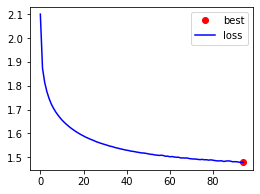

Best epoch so far:  94
Time  163.623 sec

Epoch 96 Batch 598 Loss: 1.3529
Epoch 96 Batch 1196 Loss: 1.7092
Epoch 96 Batch 1794 Loss: 1.5694
Epoch 96 Batch 2392 Loss: 1.7940
Epoch 96 Batch 2990 Loss: 1.4453
Epoch 96 Batch 3588 Loss: 1.4890

*** Epoch 96 Loss 1.4783 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  96
Time  166.050 sec

Epoch 97 Batch 598 Loss: 1.4400
Epoch 97 Batch 1196 Loss: 1.5910
Epoch 97 Batch 1794 Loss: 1.5860
Epoch 97 Batch 2392 Loss: 1.6791
Epoch 97 Batch 2990 Loss: 1.4032
Epoch 97 Batch 3588 Loss: 1.3506

*** Epoch 97 Loss 1.4769 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not going to be a good ti

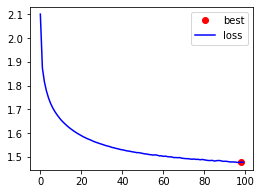

Best epoch so far:  98
Time  164.805 sec

Epoch 101 Batch 598 Loss: 1.3172
Epoch 101 Batch 1196 Loss: 1.7930
Epoch 101 Batch 1794 Loss: 1.7016
Epoch 101 Batch 2392 Loss: 1.8239
Epoch 101 Batch 2990 Loss: 1.4870
Epoch 101 Batch 3588 Loss: 1.6438

*** Epoch 101 Loss 1.4750 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not going to be a yummy 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry i am sorry 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  101
Time  165.182 sec

Epoch 102 Batch 598 Loss: 1.3980
Epoch 102 Batch 1196 Loss: 1.6288
Epoch 102 Batch 1794 Loss: 1.5694
Epoch 102 Batch 2392 Loss: 1.7163
Epoch 102 Batch 2990 Loss: 1.3533
Epoch 102 Batch 3588 Loss: 1.4034

*** Epoch 102 Loss 1.4751 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you d

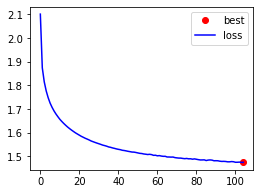

Best epoch so far:  104
Time  164.423 sec

Epoch 106 Batch 598 Loss: 1.3921
Epoch 106 Batch 1196 Loss: 1.8709
Epoch 106 Batch 1794 Loss: 1.8236
Epoch 106 Batch 2392 Loss: 1.7348
Epoch 106 Batch 2990 Loss: 1.5575
Epoch 106 Batch 3588 Loss: 1.7231

*** Epoch 106 Loss 1.4749 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not going to be a umhum 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry i am sorry 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  104
Time  164.733 sec

Epoch 107 Batch 598 Loss: 1.4159
Epoch 107 Batch 1196 Loss: 1.6642
Epoch 107 Batch 1794 Loss: 1.5277
Epoch 107 Batch 2392 Loss: 1.7135
Epoch 107 Batch 2990 Loss: 1.3766
Epoch 107 Batch 3588 Loss: 1.5131

*** Epoch 107 Loss 1.4733 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am no

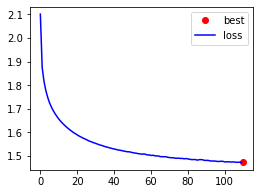

Best epoch so far:  110
Time  163.688 sec

Epoch 111 Batch 598 Loss: 1.2597
Epoch 111 Batch 1196 Loss: 1.9812
Epoch 111 Batch 1794 Loss: 1.7900
Epoch 111 Batch 2392 Loss: 1.8076
Epoch 111 Batch 2990 Loss: 1.5183
Epoch 111 Batch 3588 Loss: 1.7513

*** Epoch 111 Loss 1.4723 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am going to be a umhum 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
check point saved!
Best epoch so far:  111
Time  163.601 sec

Epoch 112 Batch 598 Loss: 1.3638
Epoch 112 Batch 1196 Loss: 1.7104
Epoch 112 Batch 1794 Loss: 1.5557
Epoch 112 Batch 2392 Loss: 1.7678
Epoch 112 Batch 2990 Loss: 1.4173
Epoch 112 Batch 3588 Loss: 1.4915

*** Epoch 112 Loss 1.4702 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am goin

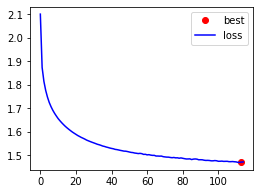

Best epoch so far:  113
Time  164.583 sec

Epoch 116 Batch 598 Loss: 1.3199
Epoch 116 Batch 1196 Loss: 2.0004
Epoch 116 Batch 1794 Loss: 1.7801
Epoch 116 Batch 2392 Loss: 1.8289
Epoch 116 Batch 2990 Loss: 1.5425
Epoch 116 Batch 3588 Loss: 1.6733

*** Epoch 116 Loss 1.4689 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am going to be a good time 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry i am sorry 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
check point saved!
Best epoch so far:  116
Time  164.095 sec

Epoch 117 Batch 598 Loss: 1.3249
Epoch 117 Batch 1196 Loss: 1.7832
Epoch 117 Batch 1794 Loss: 1.7014
Epoch 117 Batch 2392 Loss: 1.8200
Epoch 117 Batch 2990 Loss: 1.4845
Epoch 117 Batch 3588 Loss: 1.6373

*** Epoch 117 Loss 1.4702 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing 

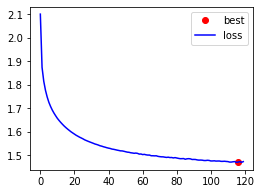

Best epoch so far:  116
Time  164.556 sec

Epoch 121 Batch 598 Loss: 1.3416
Epoch 121 Batch 1196 Loss: 1.9554
Epoch 121 Batch 1794 Loss: 1.8971
Epoch 121 Batch 2392 Loss: 1.8192
Epoch 121 Batch 2990 Loss: 1.5479
Epoch 121 Batch 3588 Loss: 1.7427

*** Epoch 121 Loss 1.4715 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  116
Time  164.775 sec

Epoch 122 Batch 598 Loss: 1.3863
Epoch 122 Batch 1196 Loss: 1.8690
Epoch 122 Batch 1794 Loss: 1.8178
Epoch 122 Batch 2392 Loss: 1.7187
Epoch 122 Batch 2990 Loss: 1.5361
Epoch 122 Batch 3588 Loss: 1.6985

*** Epoch 122 Loss 1.4680 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is you

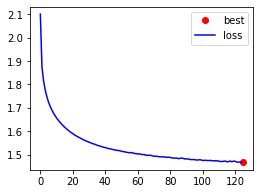

Best epoch so far:  125
Time  164.586 sec

Epoch 126 Batch 598 Loss: 1.3807
Epoch 126 Batch 1196 Loss: 1.8980
Epoch 126 Batch 1794 Loss: 1.8506
Epoch 126 Batch 2392 Loss: 1.7738
Epoch 126 Batch 2990 Loss: 1.4905
Epoch 126 Batch 3588 Loss: 1.7929

*** Epoch 126 Loss 1.4660 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am sorry 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry 
%
Greedy| Q: Do you want to go out ?  A: no i am not 
####################
check point saved!
Best epoch so far:  126
Time  163.522 sec

Epoch 127 Batch 598 Loss: 1.2453
Epoch 127 Batch 1196 Loss: 1.9714
Epoch 127 Batch 1794 Loss: 1.7844
Epoch 127 Batch 2392 Loss: 1.8114
Epoch 127 Batch 2990 Loss: 1.5004
Epoch 127 Batch 3588 Loss: 1.7163

*** Epoch 127 Loss 1.4685 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not sure 

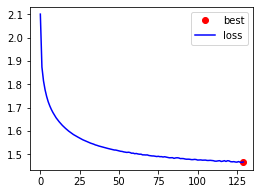

Best epoch so far:  129
Time  164.213 sec

Epoch 131 Batch 598 Loss: 1.3896
Epoch 131 Batch 1196 Loss: 1.9330
Epoch 131 Batch 1794 Loss: 1.8642
Epoch 131 Batch 2392 Loss: 1.8966
Epoch 131 Batch 2990 Loss: 1.4901
Epoch 131 Batch 3588 Loss: 1.8679

*** Epoch 131 Loss 1.4640 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am going to be a good time 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
check point saved!
Best epoch so far:  131
Time  164.149 sec

Epoch 132 Batch 598 Loss: 1.2883
Epoch 132 Batch 1196 Loss: 2.0217
Epoch 132 Batch 1794 Loss: 1.7721
Epoch 132 Batch 2392 Loss: 1.8024
Epoch 132 Batch 2990 Loss: 1.5528
Epoch 132 Batch 3588 Loss: 1.6894

*** Epoch 132 Loss 1.4644 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am 

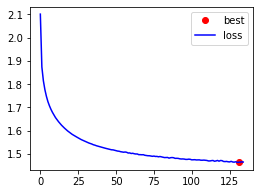

Best epoch so far:  131
Time  164.128 sec

Epoch 136 Batch 598 Loss: 1.4196
Epoch 136 Batch 1196 Loss: 1.9202
Epoch 136 Batch 1794 Loss: 1.8579
Epoch 136 Batch 2392 Loss: 1.8688
Epoch 136 Batch 2990 Loss: 1.5148
Epoch 136 Batch 3588 Loss: 1.7352

*** Epoch 136 Loss 1.4659 ***

####################
Greedy| Q: Hello   A: i am not 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am sorry i am sorry i am sorry i am sorry i am sorry i am sorry 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  131
Time  164.098 sec

Epoch 137 Batch 598 Loss: 1.3272
Epoch 137 Batch 1196 Loss: 1.9697
Epoch 137 Batch 1794 Loss: 1.9178
Epoch 137 Batch 2392 Loss: 1.8230
Epoch 137 Batch 2990 Loss: 1.5236
Epoch 137 Batch 3588 Loss: 1.7030

*** Epoch 137 Loss 1.4628 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am burning it 
%
Greedy| Q: Wha

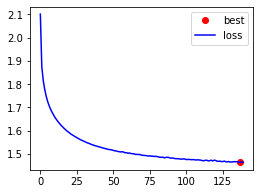

Best epoch so far:  137
Time  166.433 sec

Epoch 141 Batch 598 Loss: 1.4189
Epoch 141 Batch 1196 Loss: 1.8997
Epoch 141 Batch 1794 Loss: 1.8124
Epoch 141 Batch 2392 Loss: 1.9042
Epoch 141 Batch 2990 Loss: 1.4821
Epoch 141 Batch 3588 Loss: 1.7602

*** Epoch 141 Loss 1.4644 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am burning it 
%
Greedy| Q: What are you doing ?  A: i am going to be a umhum 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  137
Time  163.868 sec

Epoch 142 Batch 598 Loss: 1.3917
Epoch 142 Batch 1196 Loss: 1.8941
Epoch 142 Batch 1794 Loss: 1.8631
Epoch 142 Batch 2392 Loss: 1.7942
Epoch 142 Batch 2990 Loss: 1.4552
Epoch 142 Batch 3588 Loss: 1.7660

*** Epoch 142 Loss 1.4627 ***

####################
Greedy| Q: Hello   A: i am not 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am going to be a 

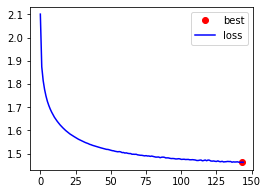

Best epoch so far:  143
Time  167.237 sec

Epoch 146 Batch 598 Loss: 1.4221
Epoch 146 Batch 1196 Loss: 1.7983
Epoch 146 Batch 1794 Loss: 1.8450
Epoch 146 Batch 2392 Loss: 1.8941
Epoch 146 Batch 2990 Loss: 1.4102
Epoch 146 Batch 3588 Loss: 1.6999

*** Epoch 146 Loss 1.4610 ***

####################
Greedy| Q: Hello   A: i am not going to 
%
Greedy| Q: How are you ?  A: i am not going to be a good time 
%
Greedy| Q: What are you doing ?  A: i am going to be a seizure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
check point saved!
Best epoch so far:  146
Time  166.869 sec

Epoch 147 Batch 598 Loss: 1.4134
Epoch 147 Batch 1196 Loss: 1.9668
Epoch 147 Batch 1794 Loss: 1.8740
Epoch 147 Batch 2392 Loss: 1.9055
Epoch 147 Batch 2990 Loss: 1.4689
Epoch 147 Batch 3588 Loss: 1.8832

*** Epoch 147 Loss 1.4613 ***

####################
Greedy| Q: Hello   A: i am not going to 
%
Greedy| Q: How are you ?  A: i am burn

In [ ]:
batch_loss = K.constant(0)
X, y = [], []
def plot_history():
    plt.figure(figsize=(4,3))
    plt.plot(best_ep,smallest_loss,'ro')
    plt.plot(history['loss'],'b-')
    plt.legend(['best','loss'])
    plt.show()

for ep in range(current_ep,EPOCHS):
    current_ep = ep    
    start = time.time()
    total_loss = 0
    btch = 1

    for p in pairs_final_train:     
        
        question = p[0]
        label = p[1]
        # find the index of each word of the caption in vocabulary
        question_seq = [wordtoix[word] for word in question.split(' ') if word in wordtoix]
        label_seq = [wordtoix[word] for word in label.split(' ') if word in wordtoix]
        # encoder input and decoder input and label
        enc_in_seq = pad_sequences([question_seq], maxlen=max_len_q, padding='post')[0]
        dec_out_seq = pad_sequences([label_seq], maxlen=max_len_a, padding='post')[0]
        
        X.append(enc_in_seq)
        y.append(dec_out_seq)

        if len(X) == batch_size :
            batch_loss = train_step(np.array(X), np.array(y), enc_hidden)
            total_loss += batch_loss
            X , y = [], []
            btch += 1
            if btch % (steps_per_epoch//6) == 0:
                print('Epoch {} Batch {} Loss: {:.4f}'.format(ep , btch, K.get_value(batch_loss)))

    epoch_loss =  K.get_value(total_loss) / steps_per_epoch
    print('\n*** Epoch {} Loss {:.4f} ***\n'.format(ep ,epoch_loss))
    history['loss'].append(epoch_loss)
    
    checkpoint.save(file_prefix = checkpoint_prefix)
    test_bot(k=5)

    if epoch_loss < smallest_loss:
        smallest_loss = epoch_loss
        best_ep = ep 
        print('check point saved!')
    
    if ep % 5 == 0:
        plot_history()
        
    print('Best epoch so far: ',best_ep)
    print('Time  {:.3f} sec\n'.format(time.time() - start))

    print('=' * 40)

Now we can load our best model and chat with our system. We also plot the attention weights.

In [28]:
checkpoint.restore(str(emb_dim)+"-ckpt-145")


In [29]:
test_bot()


####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am burning it 
%
Greedy| Q: What are you doing ?  A: i am going to be a umhum 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not sure 
%
Greedy| Q: Do you want to go out ?  A: no 
####################


Input: how old are you
Predicted answer: i am seventyfour 


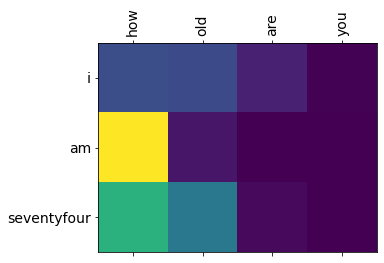

In [26]:
q = "How old are you"
answer(q, training=False)


Input: do you drink
Predicted answer: no 


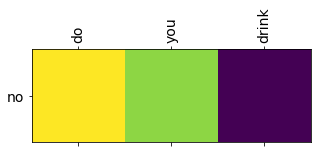

In [30]:
q = "Do you drink"
answer(q, training=False)


**Task 3** Let's look at the attention weights and compare them after 5, 50 and 140 epochs. Instead of evaluating by an automatic evaluation method, you can show us 10 predictions for each model. Answer the following questions based on your predictions, giving examples and/or explaining the evidence for your answers.


*   Did the models learn to track local relations between words?

*   Did the models attend to the least frequent tokens in an utterance? Can you see signs of overfitting in models that hang on to the least frequent words?

*   Did the models learn to track some major syntactic relations in the utterances (e.g. subject-verb, verb-object)?

*   Do they learn to encode some other linguistic features? Do they capture part-of-speech tags (POS tags)?

*   What is the effect of more training on the length of responss?

*   In some instances, by the time the decoder has to generate the beginning of a response, it may already forget the most relevant early query tokens. Can you suggest ways to change the training pipeline to make it easier for the model to remember the beginning of the query when it starts to generate the response?





















You now have a good understanding of how to build a generative conversational model. If you're interested, you can customise the chatbot's behaviour by adjusting the model and training parameters, as well as the data used to train the model.